In [1]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   108M      0  0:00:07  0:00:07 --:--:--  122M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [4]:
!ls PetImages

Cat  Dog


In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

In [6]:
import torchvision
from torchvision import datasets, transforms
import torch

# Define the transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(180),
        transforms.CenterCrop(180),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(180),
        transforms.CenterCrop(180),
        transforms.ToTensor(),
    ]),
}

# Define the datasets
data_dir = 'PetImages'
image_datasets = {x: datasets.ImageFolder(
    data_dir, data_transforms[x]) for x in ['train', 'val']}

# Define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=128, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Separate train and validation datasets
train_ds = dataloaders['train']
val_ds = dataloaders['val']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


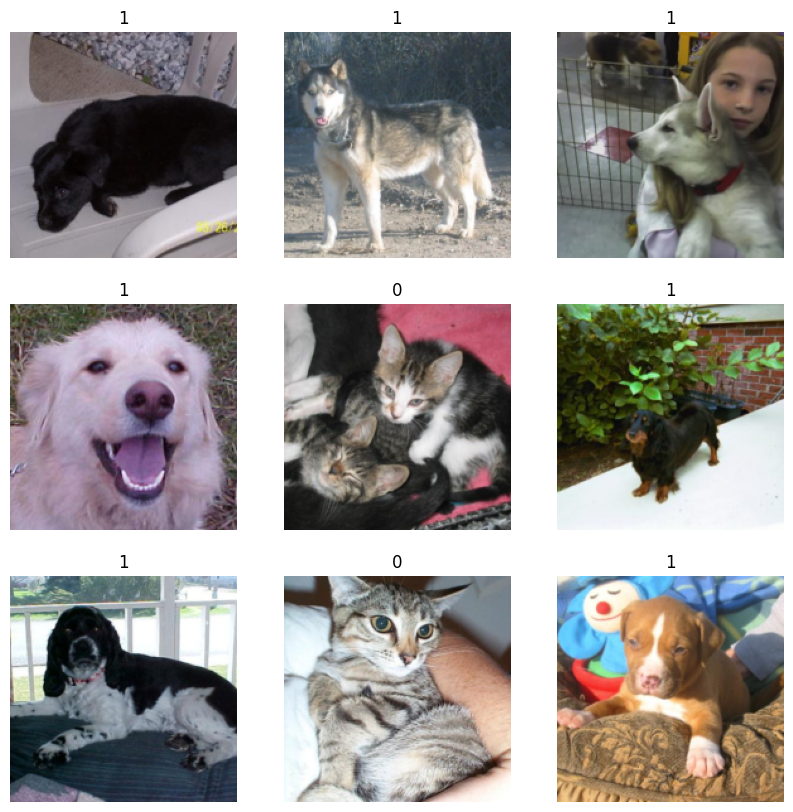

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Get a batch of training data
images, labels = next(iter(train_ds))

# Display the images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    np_image = images[i].permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.title(int(labels[i]))
    plt.axis('off')
plt.show()


In [8]:
import torchvision.transforms as transforms

data_augmentation_layers = [ transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), ]

def data_augmentation(images):
  transform = transforms.Compose(data_augmentation_layers)
  augmented_images = transform(images)
  return augmented_images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.figure(figsize=(10, 10))
for images, _ in train_ds:
    for i in range(9):
        augmented_images = data_augmentation(images)
        augmented_image = augmented_images[0].permute(1, 2, 0).numpy()  # Convert to NumPy array and rearrange dimensions
        augmented_image = (augmented_image * 255).astype("uint8")  # Convert data type
    #     ax = plt.subplot(3, 3, i + 1)
    #     plt.imshow(augmented_image)
    #     plt.axis("off")
    # plt.show()



In [ ]:
data_augmentation(images).size()

In [ ]:
augmented_images[0]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeperableConv2d(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, *args, **kwargs):
    super().__init__()
    self.depthwise = nn.Conv2d(in_channels, in_channels, *args,  groups=in_channels, **kwargs)
    self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.depthwise(x)
    x = self.pointwise(x)
    return x


class ResNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ResNet, self).__init__()
        self.entry = nn.Sequential(
            nn.Conv2d(input_shape[0], 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.blocks = nn.ModuleList()
        previous_block = None
        sizes = [256, 512, 728]
        for size in sizes:
            main_block = nn.Sequential(
                nn.ReLU(),
                SeparableConv2d(128, size, kernel_size=3, padding=1),
                nn.BatchNorm2d(size),
                nn.ReLU(),
                SeparableConv2d(size, size, kernel_size=3, padding=1),
                nn.BatchNorm2d(size),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
            self.blocks.append(main_block)
            # if previous_block is not None:
            #     residual = nn.Conv2d(128, size, kernel_size=1, stride=2, padding=1)
            #     previous_block = residual(previous_block) + main_block
            # else:
            #     previous_block = main_block

        self.final_block = nn.Sequential(
            SeparableConv2d(728, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classification = nn.Sequential(nn.Dropout(0.25),
                                            nn.Conv2d(1024, num_classes, kernel_size=1))

    def forward(self, x):
        x = self.entry(x)
        residual = x
        for block in self.blocks:
            x = block(x)
            residual = F.interpolate(residual, size=x.shape[2:])
            residual = F.conv2d(residual, block[1].weight)
            x += residual
            residual = x
        x = self.final_block(x)
        x = self.classification(x)
        x = x.view(x.size(0), -1)
        return x



In [ ]:
# Create an instance of the model
input_shape = (3, 224, 224)  # Assuming input shape is (3, 224, 224)
num_classes = 2
mymodel = ResNet(input_shape=input_shape, num_classes=num_classes)

# Print the model architecture
print(mymodel)

In [ ]:
import torch.optim as optim
epochs = 25

model = mymodel  # Replace "YourModel" with your actual model class

# Define your optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

# Training loop
for epoch in range(epochs):
  # Training
  model.train()
  for inputs, labels in train_ds:
    ptimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # Validation
  model.eval()
  with torch.no_grad():
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels in val_ds:
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * inputs.size(0)
      total_correct += (torch.sigmoid(outputs) > 0.5).eq(labels).sum().item()
      total_samples += inputs.size(0)

      val_loss = total_loss / total_samples
      val_accuracy = total_correct / total_samples

  print(f"Epoch {epoch+1}/{epochs}: Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path = "PetImages/Cat/6779.jpg"
image_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

img = Image.open(image_path)
img = transform(img).unsqueeze(0)  # Add batch dimension

# Predict the class probabilities
model.eval()
with torch.no_grad():
    predictions = model(img)
    score = torch.sigmoid(predictions).item()

# Print the prediction result
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

# Visualize the image
img = img.squeeze(0)
img = transforms.ToPILImage()(img)

plt.imshow(img)
plt.axis('off')
plt.show()